In [1]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd
from pythermalcomfort.models import pmv
from pythermalcomfort.utilities import v_relative, clo_dynamic
from scipy.signal import savgol_filter
import seaborn as sns
from pathlib import Path

sns.set_style('ticks') # setting style
sns.set_context('paper') # setting context
sns.set_palette('colorblind') # setting palette
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [12]:
DEST_PATH = Path.cwd() / Path("dest")
DATA_PATH = Path.cwd() / Path("data")
EXT = "eps"

In [13]:
met = 1.1 #metabolic rate
clo = 0.65 #clothing insulation
clo_d = clo_dynamic(clo=clo, met=met)# calculate dynamic clothing

## Convections :
**Natural convection :** $$\bar{t}_{r, natural} =\bigg[ (T_G + 273.15)^4 + \frac{0.25 \times 10^8}{\epsilon_g}\bigg(\frac{|T_G - T_a|}{D}\bigg)^{1/4}(T_G - T_a) \bigg]^{1/4} $$
**Forced convection :**  $$\bar{t}_{r, force} =\bigg[ (T_G + 273.15)^4 + \frac{1.1 \times 10^8 \times v_a^{0,6}}{\epsilon_g \times D^{0,4}}(T_G - T_a) \bigg]^{1/4} $$

In [9]:
def tr_nat(t_globe, t_db, d, epsilon_g=0.95):
    """
    This function calculates the natural convection
    Parameters:
    - t_globe: globe temperature in degree celsius
    - t_db: dry bulb temperature in degree celsius
    - d: diameter of the globe in meters
    """
    return ((t_globe + 273.15)**4 + (0.25E8 / epsilon_g) * ((abs(t_globe - t_db) / d)**(1/4)) * (t_globe - t_db))**(1/4) - 273.15

def tr_for(t_globe, t_db, d, wind_speed, epsilon_g=0.95):
    """
    This function calculates the forced convection
    Parameters:
    t_globe: globe temperature in degree celsius
    t_db: dry bulb temperature in degree celsius
    d: diameter of the globe in meters
    wind_speed: wind speed in m/s
    """
    return ((t_globe + 273.15)**4 + (1.1E8 * (wind_speed**0.6) / epsilon_g * (d**0.4)) * (t_globe - t_db)) ** (1/4) - 273.15

In [10]:
def kings_law(Tair, U,a=5.66E-6, b=3.21E-6, n=0.41, TW=79.5, RW=10E3):
    try:
        res = ((1/b)*((U**2)/(RW * (TW - Tair))-a))**(1/n)
    except FloatingPointError:
        res=  0
    return res


## Data related functions (extract / plot)

In [15]:
def get_TESTO_pmv(filename, start=None, end=None):
    """
    This function reads the TESTO data from a csv file and calculates the Predicted Mean Vote values
    Parameters:
    - filename: str, path to the csv file
    - start: str, the start time of the analysis (optional)
    - end: str, the end time of the analysis (optional)
    """

    COL_TIME = "Date/Heure"
    COL_TEMP_DB = "905 [°C]"
    COL_TEMP_GLOBE = "020 TC2 [°C]"
    COL_PRES = "020 [hPa]"
    COL_RH = "154 [%HR]"
    COL_V = "905 [m/s]"
    TESTO_data = pd.read_csv(filename, sep=';', decimal=',')
    try :
        TESTO_data[COL_TIME] = pd.to_datetime(TESTO_data[COL_TIME], format='%d/%m/%Y %H:%M')
    except ValueError:
        TESTO_data[COL_TIME] = pd.to_datetime(TESTO_data[COL_TIME], format='%d/%m/%Y %H:%M:%S')
    
    TESTO_data.set_index(COL_TIME, inplace=True)
    
    if start is not None and end is not None:
       TESTO_data = TESTO_data.between_time(start, end)
    TESTO_time = TESTO_data.index.to_numpy()
    TESTO_rh = TESTO_data[COL_RH].to_numpy()
    TESTO_temp_db = TESTO_data[COL_TEMP_DB].to_numpy()
    try:
        TESTO_temp_globe = TESTO_data[COL_TEMP_GLOBE].to_numpy()
    except KeyError:
        COL_TEMP_GLOBE = "020 TC1 [°C]"
        TESTO_temp_globe = TESTO_data[COL_TEMP_GLOBE].to_numpy()
    TESTO_pres = TESTO_data[COL_PRES].to_numpy()
    TESTO_v = TESTO_data[COL_V].to_numpy()
    #TESTO_tr = ((TESTO_temp_globe + 273.15)**4 + ((0.25*10**8)/0.95)*((np.abs(TESTO_temp_globe - TESTO_temp_db)/0.15)**(1/4))*(TESTO_temp_globe - TESTO_temp_db))**(1/4) - 273.15 #MRT
    #TESTO_tr = tr_nat(TESTO_temp_globe, TESTO_temp_db, 0.15)
    TESTO_tr = tr_for(TESTO_temp_globe, TESTO_temp_db, TESTO_v, 0.15)
    TESTO_vr = v_relative(v=TESTO_v, met=met)# calculate relative air speed
    
    TESTO_pmv = pmv(tdb=TESTO_temp_db, tr=TESTO_tr, vr=TESTO_vr, rh=TESTO_rh, met=met, clo=clo_d)
    return TESTO_time, TESTO_pmv

def get_VisAcTh_pmv(filename, start=None, end=None):
    """
    This function reads the VisAcTh data from a csv file and calculates the Predicted Mean Vote values
    Parameters:
    - filename: str, path to the csv file
    - start: str, the start time of the analysis (optional)
    - end: str, the end time of the analysis (optional)
    """
   
    COL_TIME = "time"
    COL_TEMP_DB = "tempSI7021"
    COL_TEMP_TR = "trNat"
    COL_PRES = "pres"
    COL_RH = "hum"
    COL_V = "windSpeed"
    COL_TEMP_GLOBE = "meanRadTempPin"

    VisAcTh_data = pd.read_csv(filename)    
    VisAcTh_data[COL_TIME] = pd.to_datetime(VisAcTh_data[COL_TIME])
    VisAcTh_data.set_index(COL_TIME, inplace=True)
    
    if start is not None and end is not None:
        VisAcTh_data = VisAcTh_data.between_time(start, end)
    VisAcTh_time = VisAcTh_data.index.to_numpy()
    VisAcTh_rh = VisAcTh_data[COL_RH].to_numpy()
    VisAcTh_temp_db = VisAcTh_data[COL_TEMP_DB].to_numpy()
    VisAcTh_pres = VisAcTh_data[COL_PRES].to_numpy()
    VisAcTh_v = VisAcTh_data[COL_V].to_numpy()
    v_air = list()
    for tmp, rvpin in zip(VisAcTh_temp_db, VisAcTh_data["RVPin"].to_numpy()):
        v = kings_law(tmp, rvpin*3.3/4095)    
        v_air.append(v)
    
    VisAcTh_v = np.array(v_air)
    print(np.sum(VisAcTh_data[COL_V].to_numpy() - VisAcTh_v) / len(VisAcTh_v))
    
    VisAcTh_tr = VisAcTh_data[COL_TEMP_TR].to_numpy()
    VisAcTh_vr = v_relative(v=VisAcTh_v, met=met)# calculate relative air speed
    VisAcTh_temp_globe = VisAcTh_data[COL_TEMP_GLOBE].to_numpy()
    
    epsilonG = 0.95
    D = 4E-2
    #VisAcTh_tr = tr_nat(VisAcTh_temp_globe, VisAcTh_temp_db, D)
    VisAcTh_tr = tr_for(VisAcTh_temp_globe, VisAcTh_temp_db, D,VisAcTh_v) 
    
    VisAcTh_pmv = pmv(tdb=VisAcTh_temp_db, tr=VisAcTh_tr, vr=VisAcTh_vr, rh=VisAcTh_rh, met=met, clo=clo_d)
    return VisAcTh_time, VisAcTh_pmv

In [3]:
def get_VisAcTh_illuminance(filename, start=None, end=None):
    """
    This function reads the VisAcTh data from a csv file and returns the illuminance records
    Parameters:
    - start: str, the start time of the analysis (optional)
    - end: str, the end time of the analysis (optional)
    """
    COL_TIME = "time"
    COL_ILUM = "lum"

    VisAcTh_data = pd.read_csv(filename)
    VisAcTh_data[COL_TIME] = pd.to_datetime(VisAcTh_data[COL_TIME])
    VisAcTh_data.set_index(COL_TIME, inplace=True)
    if start is not None and end is not None:
        VisAcTh_data = VisAcTh_data.between_time(start, end)
    VisAcTh_time = VisAcTh_data.index.to_numpy()
    VisAcTh_ilum = VisAcTh_data[COL_ILUM].to_numpy()

    return VisAcTh_time, VisAcTh_ilum

In [4]:
def extract_sound_ref(path, start=None, end=None):
    """
    This function reads the FI 85 ED (the reference) data from a csv file and returns the sound records
    Parameters:
    - start: str, the start time of the analysis (optional)
    - end: str, the end time of the analysis (optional)
    """
    sound_df = pd.read_csv(path, sep=";")
    sound_df["TIME"] = pd.to_datetime(sound_df["TIME"], format="%d-%m-%y/%H:%M:%S")
    sound_df.set_index("TIME", inplace=True)
    if start is not None and end is not None:
        sound_df = sound_df.between_time(start, end)
    sound_time = sound_df.index.to_numpy()
    sound_data = sound_df["SOUND"].to_numpy()
    return sound_time, sound_data
    
def extract_sound_visacth(path, start=None, end=None):
    """
    This function reads the VisAcTh data from a csv file and returns the sound records
    Parameters:
    - start: str, the start time of the analysis (optional)
    - end: str, the end time of the analysis (optional)
    """
    visAcTh_df = pd.read_csv(path)
    visAcTh_df["time"] = pd.to_datetime(visAcTh_df["time"])
    visAcTh_df.set_index("time", inplace=True)
    
    if start is not None and end is not None:
        visAcTh_df = visAcTh_df.between_time(start, end)

    visAcTh_time = visAcTh_df.index.to_numpy()
    visAcTh_sound = visAcTh_df["noiseCalib"].to_numpy()
    return visAcTh_time, visAcTh_sound

In [5]:
def plot_pmv_fig_generic(time1, data1, label1, time2, data2, label2, title, out_name, ylims=None):
    """
    This function plots the PMV values of two different datasets
    parameters:
    - time1: np.array, time of the first dataset
    - data1: np.array, PMV values of the first dataset
    - label1: str, label of the first dataset
    - time2: np.array, time of the second dataset
    - data2: np.array, PMV values of the second dataset
    - label2: str, label of the second dataset
    - title: str, title of the plot"
    - out_name: str, name of the output file
    - ylims: tuple, the limits of the y-axis (optional)
    """
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))

    ax.axhline(0.5, linestyle="--",  color="black", alpha=0.4)
    ax.axhline(-0.5, linestyle="--",  color="black", alpha=0.4)
    ax.plot(time1, data1, "+", label=label1, color="tab:blue")
    ax.plot(time2, data2, "x", label=label2, color="tab:orange") 
    ax.text(time1[0], 0.55, "Neutral - upper bound")
    ax.text(time1[0], -0.58, "Neutral - lower bound")
    ax.legend()
    ax.set_ylabel("PMV")
    ax.set_xlabel("Time")
    ax.minorticks_on()
    ax.grid(True,'major','both')
    if ylims is not None:
        ax.set_ylim(*ylims)

    fig.autofmt_xdate()
    plt.savefig(out_name)

In [6]:
def summarize_plot(pmv_VisAcTh, pmv_TESTO, noise_VisAcTh, noise_TESTO, illuminance_VisAcTh, title, fname):
    """
    This function plots the PMV, noise level and illuminance values of the VisAcTh and reference datasets (TESTO and FI 85 ED)
    Parameters:
    - pmv_VisAcTh: tuple, time and PMV values of the VisAcTh dataset
    - pmv_TESTO: tuple, time and PMV values of the TESTO dataset
    - noise_VisAcTh: tuple, time and noise level values of the VisAcTh dataset
    - noise_TESTO: tuple, time and noise level values of the TESTO dataset
    - illuminance_VisAcTh: tuple, time and illuminance values of the VisAcTh dataset
    - title: str, title of the plot
    """
    COLORS = sns.color_palette("colorblind")
    MARK_VISACTH = "x"
    COLOR_VISACTH = COLORS[1]

    MARK_FI85ED = "2"
    COLOR_FI85ED = COLORS[2]
    
    MARK_TESTO = "+"
    COLOR_TESTO = COLORS[0]
    
    fig, axs = plt.subplots(3, 1, figsize=(6,8), sharex=True, layout='constrained') # gridspec_kw={'height_ratios':[1.5,1,1]}, 
 
        
    axs[0].plot(*pmv_VisAcTh, MARK_VISACTH, label="PMV - VisAcTh", color=COLOR_VISACTH)
    axs[0].plot(*pmv_TESTO, MARK_TESTO, label="PMV - TESTO", color=COLOR_TESTO)
    axs[0].set_ylim((-3, 3))
    axs[0].axhline(0, linestyle="--",  color="black", alpha=0.4, label="Neutral vote")
    axs[0].set_ylabel("PMV", fontsize=11)

    axs[1].plot(*noise_VisAcTh, MARK_VISACTH, label="Noise level - VisAcTh", color=COLOR_VISACTH)
    axs[1].plot(*noise_TESTO, MARK_FI85ED, label="Noise level - FI85ED", color=COLOR_FI85ED)
    axs[1].set_ylabel(r"Noise level $(dB)$", fontsize=11)
    axs[1].set_ylim(35,100)
    
    axs[2].plot(*illuminance_VisAcTh, MARK_VISACTH, label="Iluminance - VisAcTh", color=COLOR_VISACTH)
    axs[2].set_ylabel(r"Illuminance $(lx)$", fontsize=11)
    for ax in axs:
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
        ax.legend()
        ax.minorticks_on()
        ax.grid(True,'major','both')
    fig.suptitle(title, fontsize=16)
    fig.autofmt_xdate()
    plt.savefig(DEST_PATH / Path(f"{fname}.{EXT}"))


In [7]:
def summarize_data(testo_fname, visacth_fname, sound_ref_fname, title, fname, start=None, end=None):
    """
    This function summarizes the PMV, noise level and illuminance values of the VisAcTh and reference datasets (TESTO and FI 85 ED)
    Parameters:
    - testo_fname: str, path to the TESTO csv file
    - visacth_fname: str, path to the VisAcTh csv file
    - sound_ref_fname: str, path to the FI 85 ED csv file
    - start: str, the start time of the analysis (optional)
    - end: str, the end time of the analysis (optional)
    - title: str, title of the plot
    """
    WINDOW_SIZE = 20
    P_ORDER = 4
    
    testo_pmv_time, testo_pmv = get_TESTO_pmv(testo_fname, start, end)
    
    
    visAcTh_pmv_time, visAcTh_pmv = get_VisAcTh_pmv(visacth_fname, start, end)
    #plot_pmv_fig_generic(testo_pmv_time, testo_pmv, "PMV - TESTO",visAcTh_pmv_time, visAcTh_pmv, "PMV - VisAcTh", "PMV", "out_pmv_24-03-06.pdf", ylims=[-1,1])
    
    
    ref_noise_time, ref_noise = extract_sound_ref(sound_ref_fname, start, end)
    visAcTh_noise_time, visAcTh_noise = extract_sound_visacth(visacth_fname, start, end)

    ref_noise_f =  savgol_filter(ref_noise, window_length=WINDOW_SIZE, polyorder=P_ORDER)
    visAcTh_noise_f =  savgol_filter(visAcTh_noise, window_length=WINDOW_SIZE, polyorder=P_ORDER)
    visAcTh_ilum_time, visAcTh_ilum = get_VisAcTh_illuminance(visacth_fname, start, end)
    summarize_plot((visAcTh_pmv_time, visAcTh_pmv), (testo_pmv_time, testo_pmv), (visAcTh_noise_time, visAcTh_noise_f), (ref_noise_time, ref_noise_f), (visAcTh_ilum_time, visAcTh_ilum),title, fname)

## Experience #1
> Place : Classroom
> 
> Date : 03/22/2024 

7.467849697198817e-05


/tmp/ipykernel_100608/1655492037.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


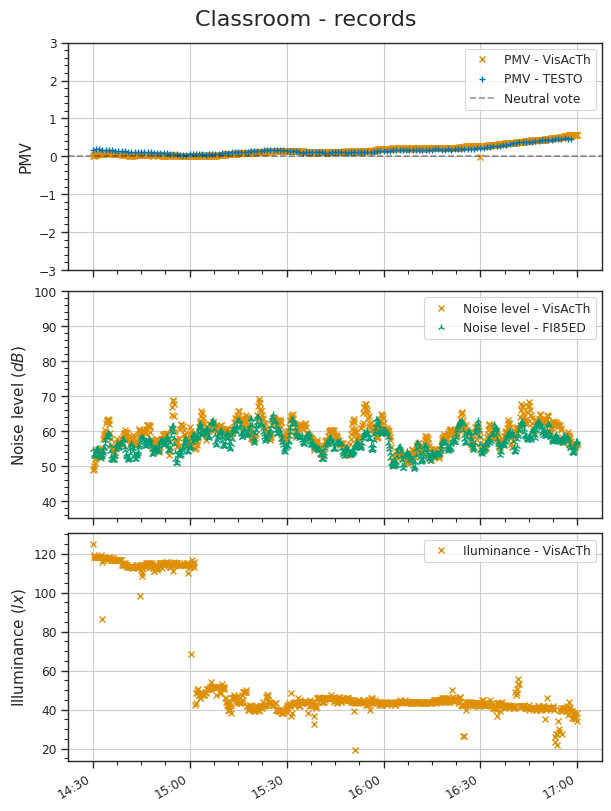

In [16]:
TESTO_FILENAME = "./data/2024-03-22/TESTO_data.csv"
VISACTH_FILENAME = "./data/2024-03-22/SENSOR_LOG_22-03-24--14-21-22.csv"
DATA_REF_SRC_F = "./data/2024-03-22/sound_ref.csv"
summarize_data(TESTO_FILENAME, VISACTH_FILENAME, DATA_REF_SRC_F, "Classroom - records", "classroom_rec", start="14:30", end="17:00")

## Experience #2
> Place: Office
> 
> Date: 04/04/2024 

0.00011280790485205212


/tmp/ipykernel_100608/1655492037.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


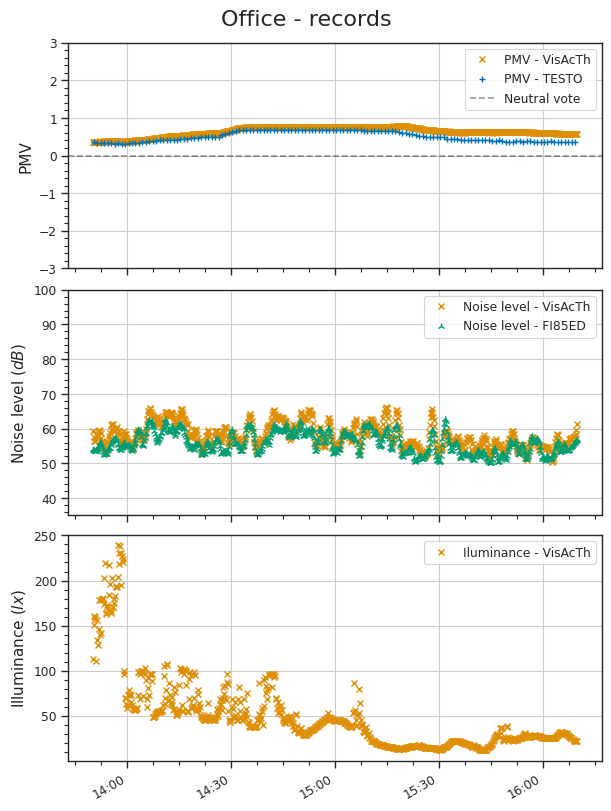

In [17]:
TESTO_FILENAME = "./data/2024-04-04/TESTO.csv"
VISACTH_FILENAME = "./data/2024-04-04/SENSOR_LOG_04-04-24--13-46-09.csv"
DATA_REF_SRC_F = "./data/2024-04-04/SOUND_REF.csv"
summarize_data(TESTO_FILENAME, VISACTH_FILENAME, DATA_REF_SRC_F, "Office - records", "office_rec", start="13:50", end="16:10")

## Experience #3
> Place: Lobby
> 
> Date: 04/05/2024 

0.00016946214599406352


/tmp/ipykernel_100608/1655492037.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


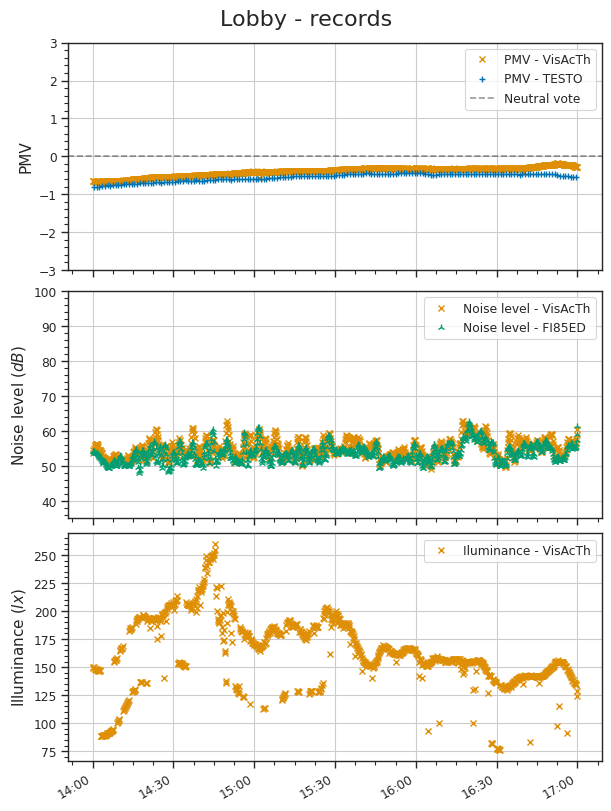

In [18]:
TESTO_FILENAME = "./data/2024-04-05/TESTO.csv"
VISACTH_FILENAME = "./data/2024-04-05/SENSOR_LOG_05-04-24--13-52-00.csv"
DATA_REF_SRC_F = "./data/2024-04-05/SOUND_REF.csv"
summarize_data(TESTO_FILENAME, VISACTH_FILENAME, DATA_REF_SRC_F, "Lobby - records", "lobby_rec", start="14:00", end="17:00")

In [14]:
def plot_pmv_fig(time1, data1, label1, time2, data2, label2, title, ylims=None):
    fig, ax = plt.subplots()
    #ax.xaxis.set_major_locator(mpl.dates.MinuteLocator(interval=2))
    start_course = np.datetime64('2024-01-22T14:01:00.000000000')
    end_course = np.datetime64('2024-01-22T17:00:00.000000000')
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))

    ax.axhline(0.5, linestyle="--",  color="black", alpha=0.4)
    ax.axhline(-0.5, linestyle="--",  color="black", alpha=0.4)
    ax.plot(time1, data1, "+", label=label1, color="tab:blue")
    ax.plot(time2, data2, "x", label=label2, color="tab:orange") 
    ax.text(time1[0], 0.55, "Neutral - upper bound")
    ax.text(time1[0], -0.58, "Neutral - lower bound")
    arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")
    offset = 50
    ax.annotate(
    f'start of the course',
    (start_course, 0.05),
    xytext=(start_course, 0.3),
    arrowprops=arrowprops)
    ax.annotate(
    f'end of the course',
    (end_course, 0.22),
    xytext=(-2.5*offset, -offset), 
    textcoords='offset points',
    arrowprops=arrowprops)
    ax.legend()
    ax.set_ylabel("Predicted Mean Vote (PMV)")
    ax.set_xlabel("Time")
    ax.minorticks_on()
    ax.grid(True,'major','both')
    if ylims is not None:
        ax.set_ylim(*ylims)

    fig.autofmt_xdate()
    plt.savefig("pmv_classroom.pdf")

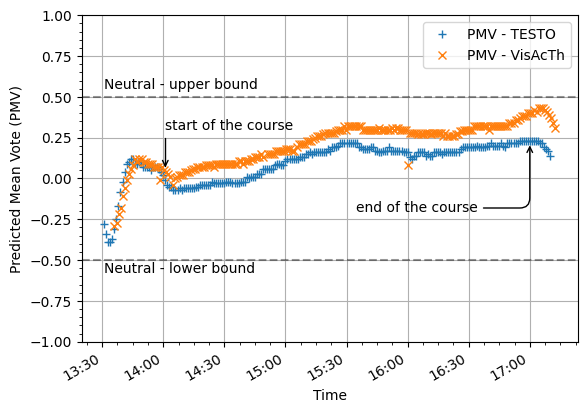

In [7]:
plot_pmv_fig(TESTO_time, TESTO_pmv, "PMV - TESTO", VisAcTh_time, VisAcTh_pmv, "PMV - VisAcTh", "PMV", ylims=[-1,1])

In [250]:
def plot_fig(time1, data1, label1, time2, data2, label2, title, ylims=None):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    ax.plot(time1, data1, "+", label=label1, color="tab:blue")
    ax.plot(time2, data2, "x", label=label2, color="tab:orange") 
    ax.legend()
    ax.set_ylabel(title)
    ax.set_xlabel("Time")
    ax.minorticks_on()
    ax.grid(True,'major','both')
    if ylims is not None:
        ax.set_ylim(*ylims)

    fig.autofmt_xdate()
    plt.savefig("pmv_classroom.pdf")

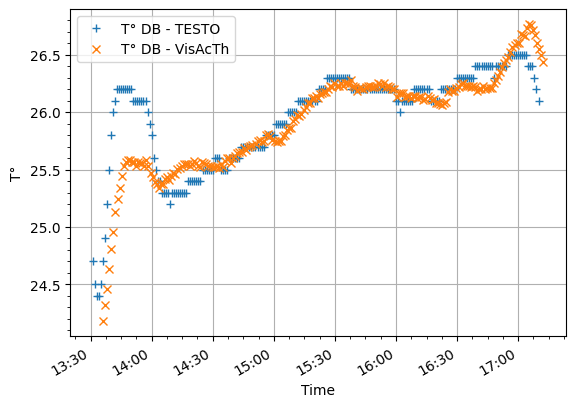

In [251]:
plot_fig(TESTO_time, TESTO_temp_db, "T° DB - TESTO", VisAcTh_time, VisAcTh_temp_db, "T° DB - VisAcTh", "T°")

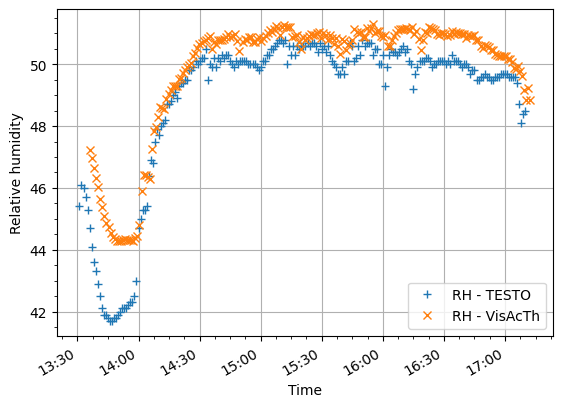

In [252]:
plot_fig(TESTO_time, TESTO_rh, "RH - TESTO", VisAcTh_time, VisAcTh_rh, "RH - VisAcTh", "Relative humidity")

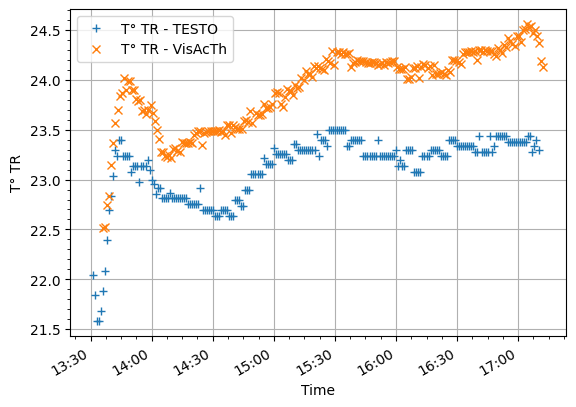

In [253]:
plot_fig(TESTO_time, TESTO_tr, "T° TR - TESTO", VisAcTh_time, VisAcTh_tr, "T° TR - VisAcTh", "T° TR")

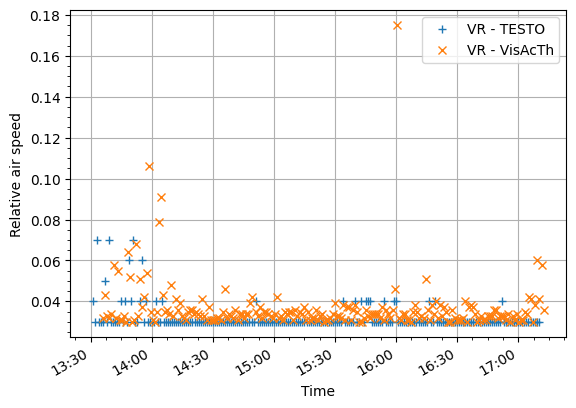

In [254]:
plot_fig(TESTO_time, TESTO_vr, "VR - TESTO", VisAcTh_time, VisAcTh_vr, "VR - VisAcTh", "Relative air speed")